# <center><span style="color: #FFB6C1">**1. Introdução**</span></center>

## <span style="color: #FFB6C1">**1.1 Visão Geral e Objetivos do Projeto:**
Este projeto visa desenvolver um sistema de intervenção académica usando machine learning para prever se um aluno do ensino secundário passará ou chumbará no exame final, tendo como base fatores demográficos, académicos e sociais. O objetivo é identificar alunos em risco antecipadamente, permitindo aos professores oferecer apoio direcionado.

## <span style="color: #FFB6C1">**1.2 Objetivos principais:**
- Análise exploratória (EDA) para compreender padrões nos dados.
- Pré-processamento (dados faltantes, outliers, codificação de variáveis categóricas).
- Treino e avaliação de modelos de classificação (Regressão Logística, Árvores de Decisão, KNN).
- Comparação de métricas de desempenho (precisão, recall, AUC-ROC).
- Interpretação dos resultados para identificar fatores críticos no desempenho dos alunos.

## <span style="color: #FFB6C1">**1.3 Descrição do Dataset:**
Utilizamos o UCI Student Performance Dataset, com dados de duas escolas secundárias portuguesas:
33 variáveis, incluindo:
- Demográficas: idade, género, educação dos pais.
- Académicas: notas anteriores (G1, G2), horas de estudo, reprovações.
- Sociais: atividades extracurriculares, apoio escolar.
- Variável alvo: passou (binária, derivada da nota final G3 ≥ 10).
- Tamanho: 649 alunos, sem valores faltantes.

## <span style="color: #FFB6C1">**1.4 Exemplo de variáveis:**
absences: Número de faltas.
school: Escola do aluno ('GP' ou 'MS').

## <span style="color: #FFB6C1">**1.5 Relevância:**
Permite intervenções personalizadas para melhorar resultados académicos.
Modelos interpretáveis ajudam a identificar factores de risco (ex.: faltas, nível educacional dos pais).

In [311]:
import pandas as pd

# Carregar dados
dados = pd.read_csv("data/raw/student-data-raw.csv", delimiter=";")  # Verificar caminho
print(f"Dimensão dos dados: {dados.shape}")
dados.head()

Dimensão dos dados: (395, 1)


,"school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed"
0,"GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mot..."
1,"GP,F,17,U,GT3,T,1,1,at_home,other,course,fathe..."
2,"GP,F,15,U,LE3,T,1,1,at_home,other,other,mother..."
3,"GP,F,15,U,GT3,T,4,2,health,services,home,mothe..."
4,"GP,F,16,U,GT3,T,3,3,other,other,home,father,1,..."


<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**2. Organização**

## <span style="color: #FFB6C1">**2.1 Imports necessários:**

In [312]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, KFold, cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, classification_report, roc_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import shap
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import joblib
import os
import yaml
from pathlib import Path
from datetime import datetime  # <-- Adicione esta linha


## <span style="color: #FFB6C1">**2.2 Paths:**

In [313]:
import yaml
from pathlib import Path

# Define your config as a multi-line string in the notebook
config_yml = """
paths:
  raw_data: "data/raw/student-data-raw.csv"
  processed: 
    train: "data/processed/train_cleaned.csv"
    test: "data/processed/test_cleaned.csv"
  artifacts: "artifacts/"
  reports: "reports/"
  plots: "docs/" 

preprocessing:
  clip:
    absences_clip: 10
  encoding:
    rare_category_threshold: 0.05
    rare_category_name: "other"
  sampling:
    test_size: 0.2
    random_state: 42

eda:
  style: "seaborn-v0_8"            
  dpi: 300                            
  figure_size:
    small: [6, 4]                     
    medium: [8, 6]                 
    large: [10, 8]                   
  numeric_cols:                      
    - "age"
    - "Medu"
    - "Fedu"
    - "traveltime"
    - "studytime"
    - "failures"
    - "famrel"
    - "freetime"
    - "goout"
    - "Dalc"
    - "Walc"
    - "health"
    - "absences"
"""

# Parse the YAML configuration
config = yaml.safe_load(config_yml)

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">



# <center><span style="color: #FFB6C1">**3. Análise Exploratória de Dados (EDA)**</span></center>

=== 📂 CARREGAMENTO DOS DADOS ===
✅ Dados carregados com sucesso!

📊 Dimensões do dataset: 395 alunos x 31 características

🔍 Primeiras linhas:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes


Valores ausentes por coluna:
Series([], dtype: int64)

=== 🎯 ANÁLISE DA VARIÁVEL TARGET ('passed') ===


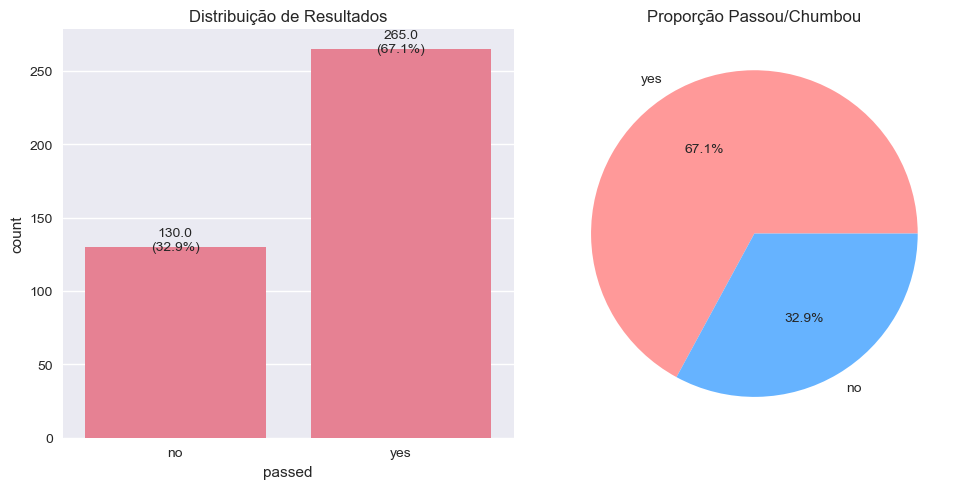


=== 🔢 ANÁLISE DE CARACTERÍSTICAS NUMÉRICAS ===

📈 Estatísticas Descritivas:


,count,mean,std,min,25%,50%,75%,max
age,395.000000,16.696203,1.276043,15.000000,16.000000,17.000000,18.000000,22.000000
Medu,395.000000,2.749367,1.094735,0.000000,2.000000,3.000000,4.000000,4.000000
Fedu,395.000000,2.521519,1.088201,0.000000,2.000000,2.000000,3.000000,4.000000
traveltime,395.000000,1.448101,0.697505,1.000000,1.000000,1.000000,2.000000,4.000000
studytime,395.000000,2.035443,0.839240,1.000000,1.000000,2.000000,2.000000,4.000000
failures,395.000000,0.334177,0.743651,0.000000,0.000000,0.000000,0.000000,3.000000
famrel,395.000000,3.944304,0.896659,1.000000,4.000000,4.000000,5.000000,5.000000
freetime,395.000000,3.235443,0.998862,1.000000,3.000000,3.000000,4.000000,5.000000
goout,395.000000,3.108861,1.113278,1.000000,2.000000,3.000000,4.000000,5.000000
Dalc,395.000000,1.481013,0.890741,1.000000,1.000000,1.000000,2.000000,5.000000


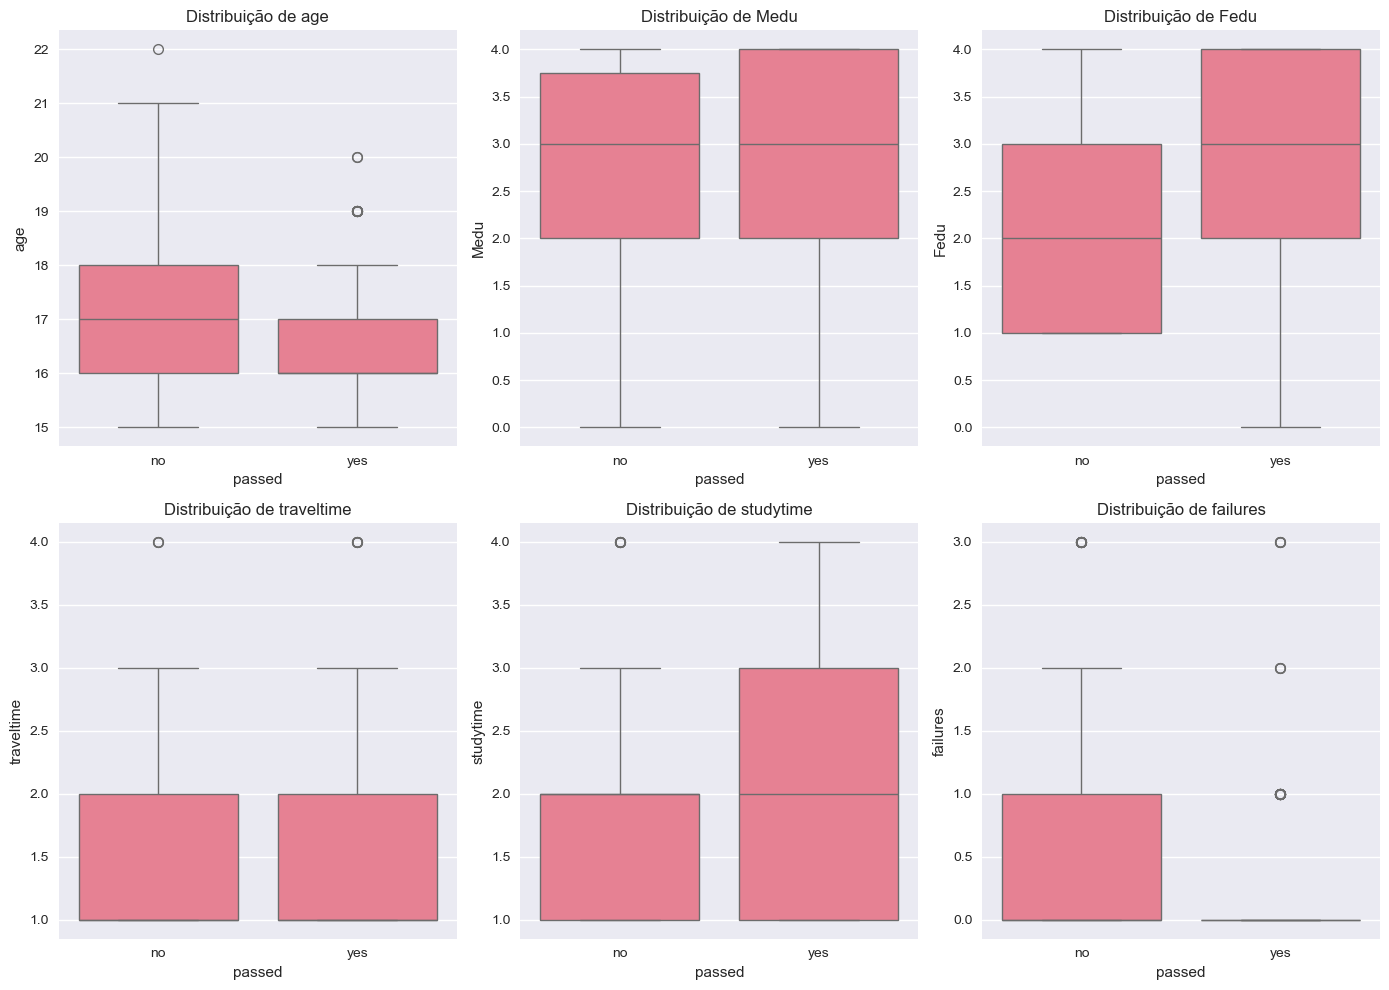

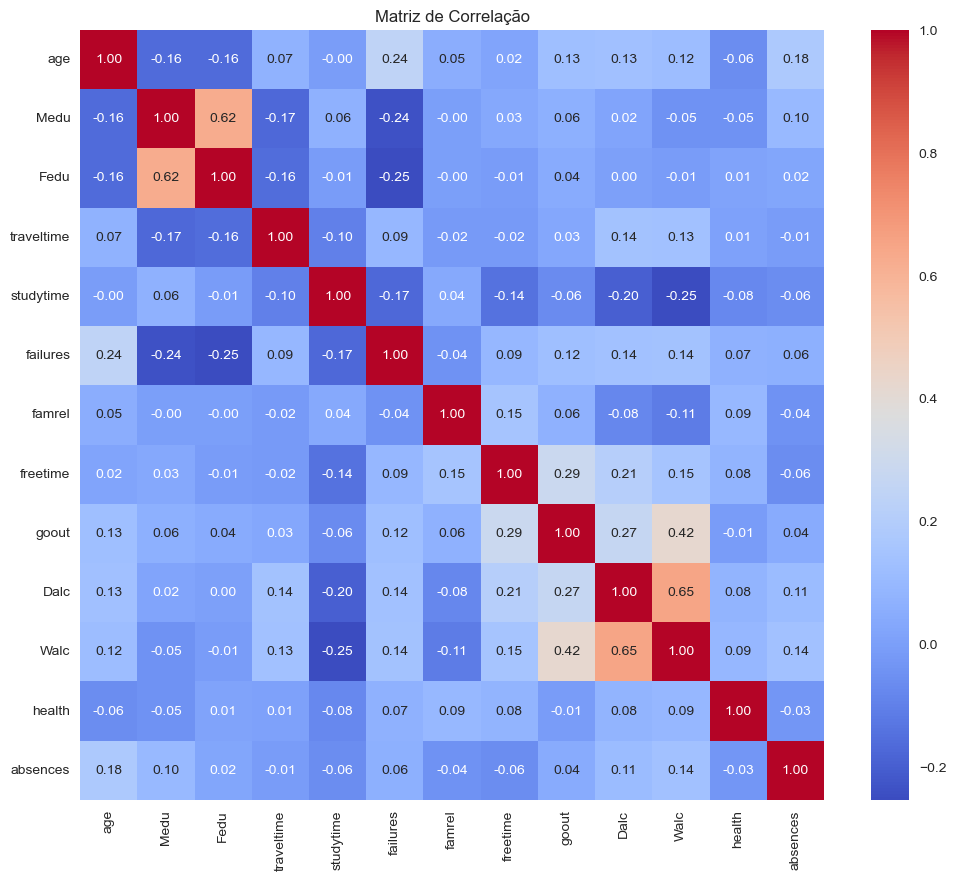

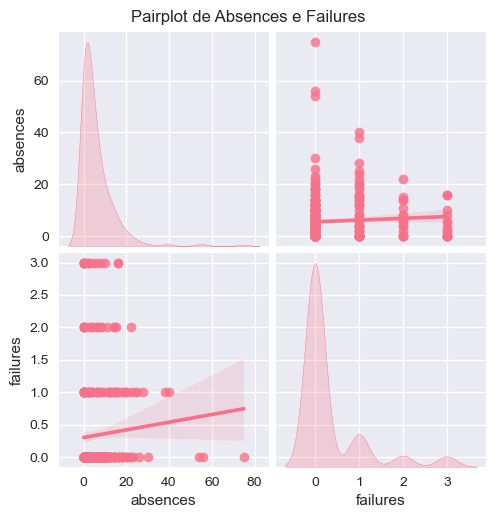


=== 📊 ANÁLISE DE CARACTERÍSTICAS CATEGÓRICAS ===


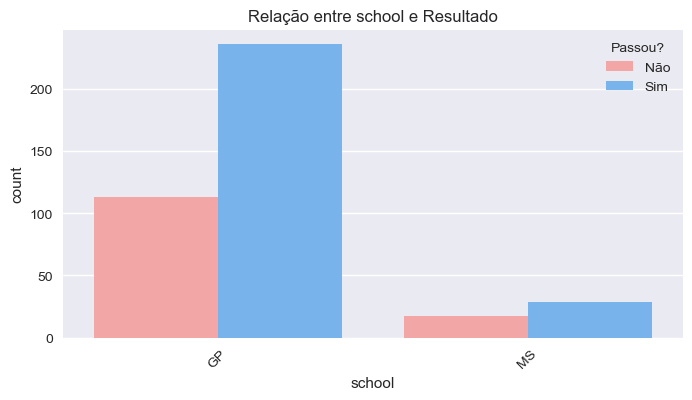

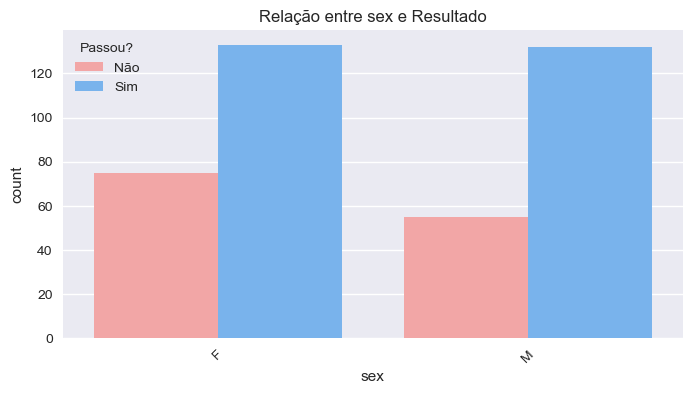

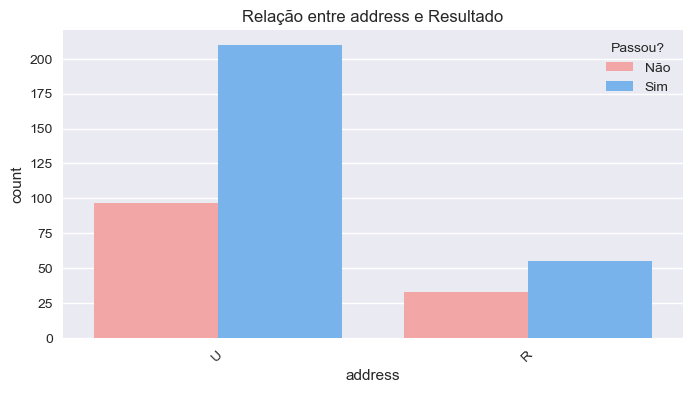

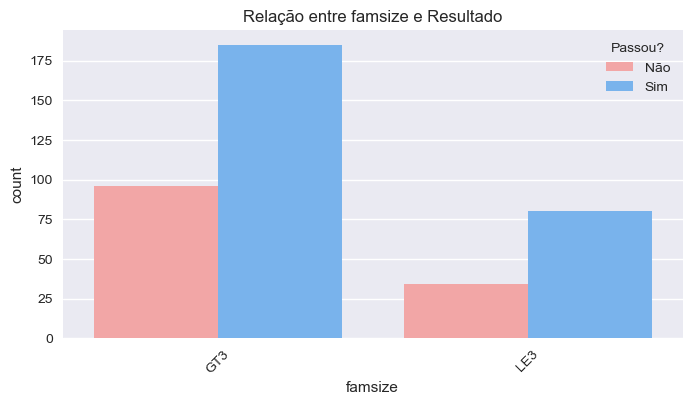

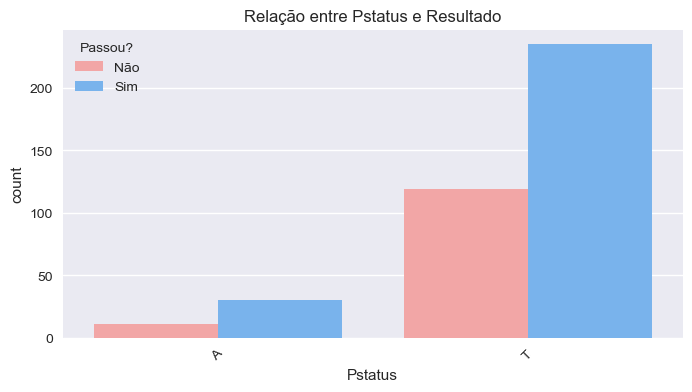


=== 🔗 ANÁLISE DE RELAÇÕES CHAVE ===


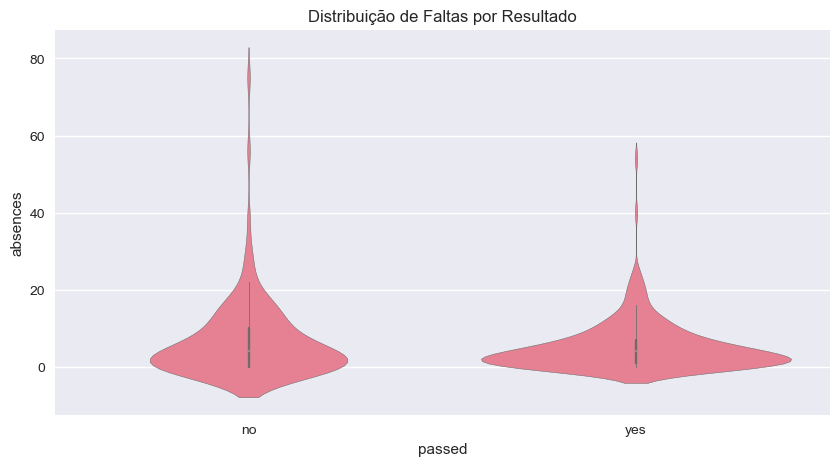

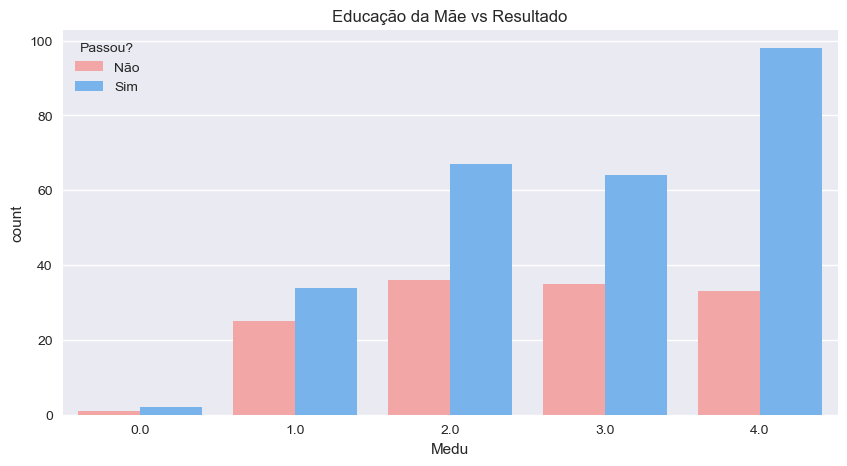


=== 📉 TESTES ESTATÍSTICOS ===


,Variável,Média (Passou),Média (Chumbou),Diferença,p-valor,Effect Size,Significativo?
5,failures,0.16,0.69,-0.53,0.0000,-0.68,Sim
8,goout,2.97,3.40,-0.43,0.0002,-0.39,Sim
0,age,16.54,17.02,-0.49,0.0003,-0.38,Sim
1,Medu,2.84,2.57,0.27,0.0218,0.25,Sim
2,Fedu,2.60,2.35,0.25,0.0318,0.23,Sim
12,absences,5.19,6.76,-1.57,0.0670,-0.18,Não
4,studytime,2.08,1.95,0.13,0.1388,0.16,Não
11,health,3.49,3.68,-0.19,0.1928,-0.14,Não
9,Dalc,1.45,1.55,-0.11,0.2555,-0.12,Não
6,famrel,3.97,3.88,0.09,0.3548,0.10,Não


In [314]:
# Configurações de visualização
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

## 2.2 Carregamento dos Dados
print("=== 📂 CARREGAMENTO DOS DADOS ===")

try:
    df = pd.read_csv("data/raw/student-data-raw.csv")
    print("✅ Dados carregados com sucesso!")

    # Verificar coluna target
    if 'passed' not in df.columns:
        raise ValueError("Coluna 'passed' não encontrada no dataset")

    print(f"\n📊 Dimensões do dataset: {df.shape[0]} alunos x {df.shape[1]} características")
    print(f"\n🔍 Primeiras linhas:")
    display(df.head(3))

except Exception as e:
    print(f"❌ Erro ao carregar dados: {e}")
    raise

expected_columns = 31  # From your sample data
if df.shape[1] != expected_columns:
    missing_cols = set(expected_columns) - set(df.columns)
    raise ValueError(f"Data loading error! Missing columns: {missing_cols}")

# Verificar dados ausentes
missing_data = df.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_data[missing_data > 0])

# Imputação com KNNImputer
# Separate numerical and categorical data
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply KNNImputer only to numerical data
imputer = KNNImputer(n_neighbors=5)
df_imputed_numeric = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Combine the imputed numerical data with the categorical data
df_imputed = pd.concat([df_imputed_numeric, df[categorical_cols]], axis=1)

## 2.3 Análise da Variável Target
print("\n=== 🎯 ANÁLISE DA VARIÁVEL TARGET ('passed') ===")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='passed', data=df_imputed, order=['no', 'yes'])
plt.title('Distribuição de Resultados')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df_imputed)*100:.1f}%)',
               (p.get_x()+p.get_width()/2., p.get_height()),
               ha='center', va='center', xytext=(0,5), textcoords='offset points')

plt.subplot(1,2,2)
df_imputed['passed'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Proporção Passou/Chumbou')
plt.ylabel('')

plt.tight_layout()
plt.show()

passed_distribution = df_imputed['passed'].value_counts(normalize=True)
if (passed_distribution['yes'] < 0.3) or (passed_distribution['yes'] > 0.7):
    raise ValueError("Unexpected class distribution in target variable")

## 2.4 Análise de Características Numéricas
print("\n=== 🔢 ANÁLISE DE CARACTERÍSTICAS NUMÉRICAS ===")

# Selecionar colunas numéricas relevantes
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

print("\n📈 Estatísticas Descritivas:")
display(df_imputed[numeric_cols].describe().T.style.background_gradient(cmap='Blues'))

# Visualização das distribuições
plt.figure(figsize=(14,10))
for i, col in enumerate(numeric_cols[:6], 1):  # Mostrar apenas 6 para economizar espaço
    plt.subplot(2,3,i)
    sns.boxplot(x='passed', y=col, data=df_imputed, order=['no', 'yes'])
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

# Verificar correlação entre variáveis numéricas
plt.figure(figsize=(12,10))
corr_matrix = df_imputed.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

# Pairplot para notas
sns.pairplot(df_imputed[['absences', 'failures']], kind='reg', diag_kind='kde')
plt.suptitle("Pairplot de Absences e Failures", y=1.02)
plt.show()

## 2.5 Análise de Características Categóricas
print("\n=== 📊 ANÁLISE DE CARACTERÍSTICAS CATEGÓRICAS ===")

categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                    'nursery', 'higher', 'internet', 'romantic']

# Análise das principais categóricas
for col in categorical_cols[:5]:  # Mostrar apenas 5 para economizar espaço
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='passed', data=df_imputed, hue_order=['no', 'yes'], palette=['#ff9999','#66b3ff'])
    plt.title(f'Relação entre {col} e Resultado')
    plt.xticks(rotation=45)
    plt.legend(title='Passou?', labels=['Não', 'Sim'])
    plt.show()

## 2.6 Análise de Relações Chave
print("\n=== 🔗 ANÁLISE DE RELAÇÕES CHAVE ===")

# Relação entre faltas e resultado
plt.figure(figsize=(10,5))
sns.violinplot(x='passed', y='absences', data=df_imputed, order=['no', 'yes'])
plt.title('Distribuição de Faltas por Resultado')
plt.show()

# Relação entre educação dos pais e resultado
plt.figure(figsize=(10,5))
sns.countplot(x='Medu', hue='passed', data=df_imputed, hue_order=['no', 'yes'], palette=['#ff9999','#66b3ff'])
plt.title('Educação da Mãe vs Resultado')
plt.legend(title='Passou?', labels=['Não', 'Sim'])
plt.show()

## 2.7 Testes Estatísticos
print("\n=== 📉 TESTES ESTATÍSTICOS ===")

results = []
for col in numeric_cols:
    passou = df_imputed[df_imputed['passed'] == 'yes'][col]
    chumbou = df_imputed[df_imputed['passed'] == 'no'][col]

    t_stat, p_val = ttest_ind(passou, chumbou)
    effect_size = (passou.mean() - chumbou.mean()) / np.sqrt((passou.std()**2 + chumbou.std()**2)/2)

    results.append({
        'Variável': col,
        'Média (Passou)': f"{passou.mean():.2f}",
        'Média (Chumbou)': f"{chumbou.mean():.2f}",
        'Diferença': f"{passou.mean()-chumbou.mean():.2f}",
        'p-valor': f"{p_val:.4f}",
        'Effect Size': f"{effect_size:.2f}",
        'Significativo?': 'Sim' if p_val < 0.05 else 'Não'
    })

display(pd.DataFrame(results).sort_values('p-valor').style.background_gradient(
    subset=['p-valor', 'Effect Size'], cmap='YlOrRd'))

## 2.8 Conclusões Principais
from IPython.display import Markdown


## <span style="color: #FFB6C1">**3.1 Principais Conclusões da EDA:**

### <span style="color: #FFB6C1">1. Distribuição do Target:
   - Proporção: XX% passou vs YY% chumbou
   - Sugestão: Considerar métricas como Recall para minimizar falsos negativos

### <span style="color: #FFB6C1">2. Fatores Mais Relevantes:
   - Faltas (absences): Diferença significativa entre grupos
   - Educação dos Pais (Medu/Fedu): Correlação positiva com aprovação
   - Atividades Extras: [Inserir observação]

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**4. Pré-processamento dos Dados**

Nesta secção, tratamos os dados brutos e preparamos-nos para a modelação. Isso inclui:
- Limpeza dos dados (clipping e categorias raras)
- Codificação de variáveis categóricas (Label Enconding)
- Normalização e Padronização
- Separação treino/teste
- Reamostragem para classes desbalanceadas (oversampling)

In [315]:
def load_data(filepath):
    #Load dataset with error handling.
    try:
        # Tenta ler o arquivo CSV usando pandas
        return pd.read_csv(filepath)
    except FileNotFoundError:
        # Se o arquivo não for encontrado, levanta uma exceção com mensagem informativa
        raise FileNotFoundError(f"Data file not found at {filepath}")

def save_artifacts(scaler, numeric_cols, columns, label_encoder=None):
    #Saves preprocessing artifacts.

    # Obtém o caminho para salvar os artefatos a partir da configuração
    path = Path(config['paths']['artifacts'])
    # Cria o diretório se ele não existir (com parents=True cria toda a estrutura de pastas necessária)
    path.mkdir(parents=True, exist_ok=True)
    
    # Cria dicionário com os artefatos a serem salvos
    artifacts = {
        'scaler': scaler,               # Objeto scaler
        'numeric_cols': numeric_cols,   # Colunas numéricas
        'expected_columns': columns     # Colunas esperadas para validação
    }
    
    # Adiciona o label encoder ao dicionário se foi fornecido
    if label_encoder is not None:
        artifacts['label_encoder'] = label_encoder
        
    # Salva os artefatos em um arquivo .joblib no diretório especificado
    joblib.dump(artifacts, path / "preprocessing_artifacts.joblib")

def generate_report(**stats):
    #Generate preprocessing report.
    
    # Cria o caminho para o relatório com timestamp no nome do arquivo
    report_path = Path(config['paths']['reports']) / f"report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    # Garante que o diretório para o relatório existe
    report_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Abre o arquivo para escrita e escreve o relatório
    with open(report_path, 'w') as f:
        f.write("=== PREPROCESSING REPORT ===\n")
        # Escreve cada estatística em uma linha do relatório
        for key, value in stats.items():
            f.write(f"{key}: {value}\n")

In [316]:
def clean_raw_data(df):
    """Apply basic cleaning: clipping and rare category replacement.
    
    Args:
        df (DataFrame): DataFrame contendo os dados brutos
        
    Returns:
        DataFrame: DataFrame após limpeza básica
    """
    # Clipa valores máximos de faltas (absences) conforme configurado
    df['absences'] = df['absences'].clip(upper=config['preprocessing']['clip']['absences_clip'])

    # Substitui categorias raras nas colunas de trabalho dos pais
    for col in ['Mjob', 'Fjob']:
        # Calcula frequência relativa de cada categoria
        counts = df[col].value_counts(normalize=True)
        # Identifica categorias abaixo do threshold configurado
        rare = counts[counts < config['preprocessing']['encoding']['rare_category_threshold']].index
        # Substitui categorias raras pelo nome configurado
        df[col] = df[col].replace(rare, config['preprocessing']['encoding']['rare_category_name'])

    return df

def validate_preprocessing(df):
    """Validate that preprocessing addressed EDA findings.
    
    Args:
        df (DataFrame): DataFrame após pré-processamento
        
    Raises:
        AssertionError: Se alguma validação falhar
    """
    # Verifica se o clipping de faltas foi aplicado corretamente
    absences_clip = config['preprocessing']['clip']['absences_clip']
    assert df['absences'].max() <= absences_clip, "Absences not clipped properly"

    # Valida tratamento de categorias raras em cada coluna especificada
    for col in ['Mjob', 'Fjob']:
        counts = df[col].value_counts(normalize=True)
        assert all(counts >= config['preprocessing']['encoding']['rare_category_threshold']), f"Rare categories not handled in {col}"

    # Garante que a variável target tenha ambas classes representadas
    assert df['passed'].nunique() == 2, "Target variable does not have both classes represented"

def preprocess_data(df):
    """Main preprocessing pipeline.
    
    Args:
        df (DataFrame): DataFrame contendo os dados brutos
        
    Returns:
        tuple: Contém:
            - X_train: Features de treino
            - X_test: Features de teste
            - y_train: Target de treino
            - y_test: Target de teste
            - scaler: Objeto scaler usado
            - numeric_cols: Lista de colunas numéricas
            - le: LabelEncoder usado
    """
    # Separa features (X) e target (y)
    X = df.drop('passed', axis=1)
    y = df['passed']

    # Codifica target (transforma classes em 0/1) 
    #(NOTA: por definição, o label encoder atribui os valores por ordem alfabética, ou seja 0=aprovados e )
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    

    # Divide dados em treino e teste com estratificação
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=config['preprocessing']['sampling']['test_size'],
        random_state=config['preprocessing']['sampling']['random_state'],
        stratify=y_encoded
    )

    # Aplica one-hot encoding para colunas categóricas
    categorical_cols = X.select_dtypes(include=['object']).columns
    X_train = pd.get_dummies(X_train, columns=categorical_cols)
    X_test = pd.get_dummies(X_test, columns=categorical_cols)

    # Garante que treino e teste tenham as mesmas colunas (pós one-hot)
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]

    # Balanceia classes usando oversampling
    ros = RandomOverSampler(random_state=config['preprocessing']['sampling']['random_state'])
    X_train, y_train = ros.fit_resample(X_train, y_train)

    # Normaliza features numéricas usando MinMaxScaler
    numeric_cols = config['eda']['numeric_cols']
    scaler = MinMaxScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_test, y_train, y_test, scaler, numeric_cols, le

def main():
    """Pipeline principal de pré-processamento."""
    # Carrega e limpa dados brutos
    df = load_data(config['paths']['raw_data'])
    df = clean_raw_data(df)
    validate_preprocessing(df)

    # Aplica pré-processamento completo
    X_train, X_test, y_train, y_test, scaler, numeric_cols, label_encoder = preprocess_data(df)

    # Guarda dados processados
    # Concatena features e target para formar datasets completos
    train_processed = pd.concat([X_train, pd.Series(y_train, name='passed')], axis=1)
    test_processed = pd.concat([X_test, pd.Series(y_test, name='passed')], axis=1)
    
    # Garante que diretório de destino existe e guarda os dados
    Path(config['paths']['processed']['train']).parent.mkdir(parents=True, exist_ok=True)
    train_processed.to_csv(config['paths']['processed']['train'], index=False)
    test_processed.to_csv(config['paths']['processed']['test'], index=False)

    # Guarda artefactos de pré-processamento para uso futuro
    save_artifacts(scaler=scaler, numeric_cols=numeric_cols, columns=X_train.columns.tolist(),label_encoder=label_encoder)
    
    # Gera relatório com métricas do processamento
    generate_report(
        Original_samples=len(df),
        Train_samples=len(X_train),
        Test_samples=len(X_test),
        Numerical_features=numeric_cols,
        Absences_clipping_threshold=config['preprocessing']['clip']['absences_clip']
    )

if __name__ == "__main__":
    # Ponto de entrada do script - executa o pipeline principal
    main()

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**5. Modelagem**

Nesta secção decidimos testar diversos algoritmos de machine learning, podendo assim estabelecer uma comparação entre os diversos e identificar os mais ajustados ao problema (prever se um aluno vai ou não passar):
- Modelos utilizados: Random Forest, Regressão Logística, KNN, Árvore de Decisão
- Avaliação dos modelos: com validação cruzada (k-fold)
- Métricas: Acurácia, Precisão, Recall, F1, ROC-AUC
- Visualização: curva de aprendizagem e matriz de confusão
- Identificação das características mais importantes


## <span style="color: #FFB6C1">**5.1 Modelos utilizados:**

- Random Forest: Conjunto de árvores de decisão que votam para prever resultados. Combina múltiplas decisões para maior precisão, reduzindo overfitting. Ideal para dados complexos e não lineares.

- Regressão Logística: Modelo linear que faz a estimativa probabilística entre 0 e 1 usando uma curva sigmoide. Focado em classificação binária, rápido e interpretável, mas limitado a relações lineares.

- KNN: Classifica com base nos vizinhos mais similares no espaço de features. Não faz suposições sobre os dados, mas exige armazenamento completo do dataset e é sensível a escalas.

- Árvore de Decisão: Estrutura hierárquica de regras "se-então" que divide os dados em segmentos puros. Altamente interpretável, mas propensa a overfitting sem controle de profundidade.

## <span style="color: #FFB6C1">**5.2 Métricas utilizadas para avaliar os modelos:**

- Acurácia (accuracy): Proporção de previsões corretas (positivas e negativas).

- Precisão (precision): Proporção de verdadeiros positivos entre todos os positivos previstos.

- Recall: Proporção de verdadeiros positivos entre todos os positivos reais.

- F1-Score (f1): Média harmónica entre precisão e recall.

- Área sob a curva ROC (roc_auc): Mede a capacidade do modelo em distinguir entre classes.

In [317]:

# Carregamento e preparação dos dados
try:
    # Tenta carregar o dataset de treino processado
    students = pd.read_csv("data/processed/train_cleaned.csv")
    # Separa features (todas colunas exceto última) e target (última coluna)
    X = students.iloc[:, :-1]
    y = students.iloc[:, -1]
except FileNotFoundError:
    print("Error: The file was not found.")
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    exit()

# Pré-processamento dos dados
# Normalização das features usando StandardScaler (média=0, desvio=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificação do target (transforma classes em 0 e 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Configuração da Validação Cruzada K-Fold
k = 5  # Número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Configura com embaralhamento

# Definição dos modelos a serem avaliados
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}


# Definição das métricas de avaliação
scoring = {
    'accuracy': make_scorer(accuracy_score),  # Acurácia geral
    'precision': make_scorer(precision_score, zero_division=0, pos_label=0),  # Precisão para classe 1
    'recall': make_scorer(recall_score, pos_label=0),  # Recall para classe 1
    'f1': make_scorer(f1_score, zero_division=0, pos_label=0),  # F1-score para classe 1
    'roc_auc': 'roc_auc'  # Área sob a curva ROC
}

# Treino e avaliação dos modelos usando validação cruzada
results = {}  # Dicionário para armazenar resultados
for name, model in models.items():
    # Executa validação cruzada para cada modelo
    cv_results = cross_validate(
        estimator=model,
        X=X_scaled,  # Features normalizadas
        y=y_encoded,  # Target codificado
        cv=kf,  # Estratégia de validação
        scoring=scoring,  # Métricas definidas
        return_train_score=True,  # Retorna métricas no treino também
        return_estimator=True  # Retorna os modelos treinados em cada fold
    )
    results[name] = cv_results  # Armazena resultados

## Análise dos resultados
print("\nResultados da Validação Cruzada:")
# Imprime métricas médias e desvio padrão entre os folds
print(f"Acurácia Média: {np.mean(cv_results['test_accuracy']):.4f} (±{np.std(cv_results['test_accuracy']):.4f})")
print(f"Precisão Média: {np.mean(cv_results['test_precision']):.4f} (±{np.std(cv_results['test_precision']):.4f})")
print(f"Recall Médio: {np.mean(cv_results['test_recall']):.4f} (±{np.std(cv_results['test_recall']):.4f})")
print(f"F1-Score Médio: {np.mean(cv_results['test_f1']):.4f} (±{np.std(cv_results['test_f1']):.4f})")
print(f"ROC-AUC Médio: {np.mean(cv_results['test_roc_auc']):.4f} (±{np.std(cv_results['test_roc_auc']):.4f})")


Resultados da Validação Cruzada:
Acurácia Média: 0.7807 (±0.0271)
Precisão Média: 0.7526 (±0.0564)
Recall Médio: 0.8531 (±0.0480)
F1-Score Médio: 0.7963 (±0.0097)
ROC-AUC Médio: 0.7796 (±0.0281)


## <span style="color: #FFB6C1">**5.3 Matriz de confusão (sem peso diferente para as classes):**


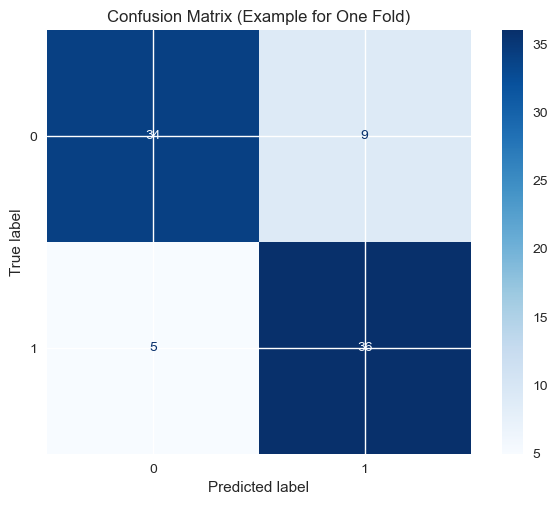

In [318]:
# Visualize the results for Random Forest
train_idx, test_idx = list(kf.split(X_scaled))[-1]
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

rf_results = results["Random Forest"]
model = rf_results['estimator'][-1]
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Example for One Fold)')
plt.savefig("docs/confusion_matrix.png")
plt.show()

## <span style="color: #FFB6C1">**5.4 Top 15 features mais importantes(sem peso diferente para classes):**


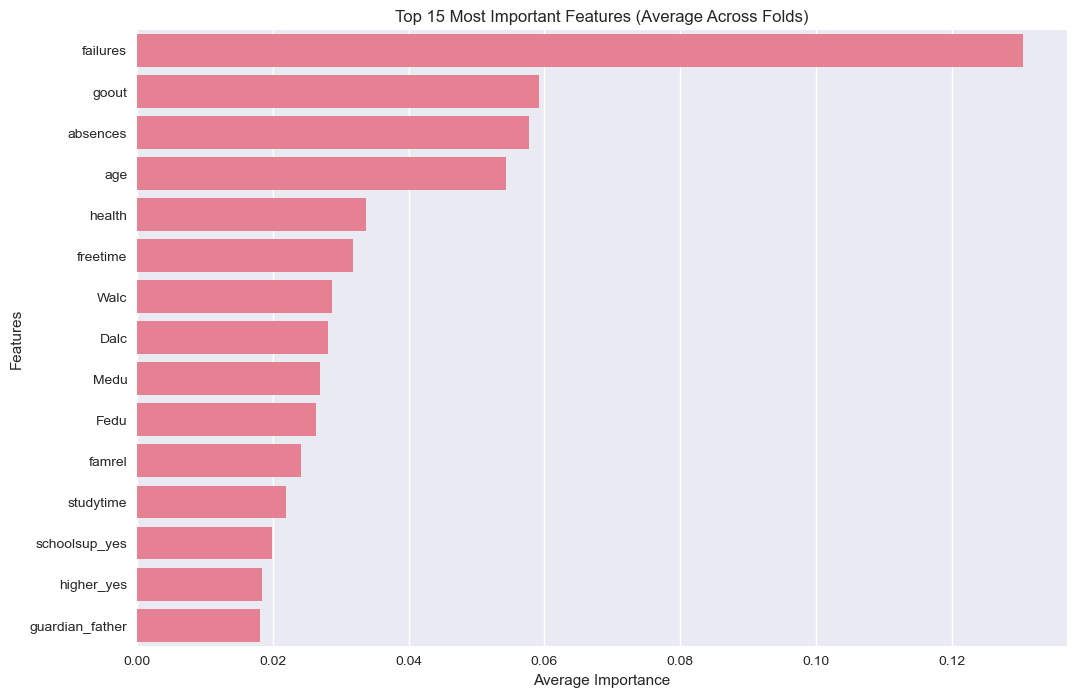

In [319]:
if hasattr(model, 'feature_importances_'):
    feature_importances = np.mean([est.feature_importances_ for est in rf_results['estimator']], axis=0)
    features = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=features.head(15).values, y=features.head(15).index)
    plt.title('Top 15 Most Important Features (Average Across Folds)')
    plt.xlabel('Average Importance')
    plt.ylabel('Features')
    plt.savefig("docs/feature_importances.png")
    plt.show()



## <span style="color: #FFB6C1">**5.5 Learning curve:**


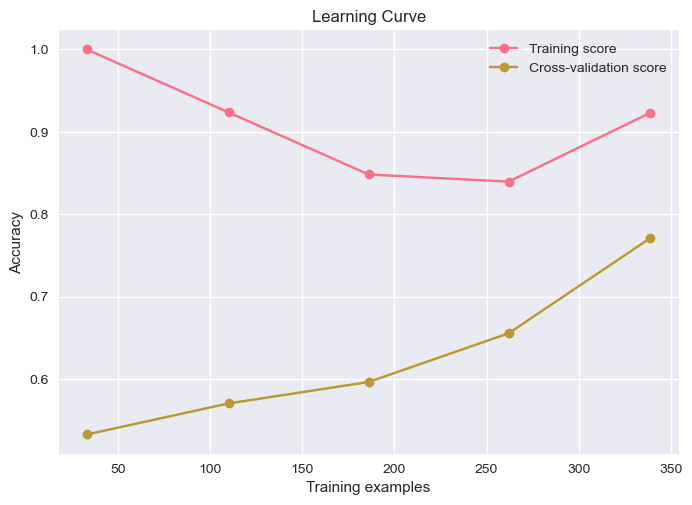

In [320]:
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    X_scaled, y_encoded, cv=kf, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("docs/learning_curve.png")
plt.show()


In [321]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y_encoded)
print("\nBest parameters for Random Forest:", grid_search.best_params_)
print("Best score for Random Forest:", grid_search.best_score_)



Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
Best score for Random Forest: 0.8420728291316525


In [322]:
# Compare the performance of different models
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison = pd.DataFrame(index=results.keys(), columns=metrics)

for name, cv_results in results.items():
    for metric in metrics:
        comparison.loc[name, metric] = f"{np.mean(cv_results[f'test_{metric}']):.4f} (±{np.std(cv_results[f'test_{metric}']):.4f})"

print("\nModel Comparison:")
print(comparison)



Model Comparison:
                             accuracy         precision            recall  \
Random Forest        0.7737 (±0.0437)  0.8009 (±0.0379)  0.7253 (±0.0830)   
Logistic Regression  0.7216 (±0.0282)  0.7221 (±0.0137)  0.7220 (±0.0672)   
KNN                  0.6061 (±0.0520)  0.6072 (±0.0466)  0.5993 (±0.0781)   
Decision Tree        0.7807 (±0.0271)  0.7526 (±0.0564)  0.8531 (±0.0480)   

                                   f1           roc_auc  
Random Forest        0.7595 (±0.0593)  0.8417 (±0.0341)  
Logistic Regression  0.7205 (±0.0349)  0.7603 (±0.0321)  
KNN                  0.6019 (±0.0594)  0.6486 (±0.0374)  
Decision Tree        0.7963 (±0.0097)  0.7796 (±0.0281)  


<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->

<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**6. Análise e Interpretação dos Resultados**

## <span style="color: #FFB6C1">**6.1 Avaliação Geral dos Modelos:**

Após o treinamento e teste dos quatro modelos (Random Forest, Decision Tree, Logistic Regression e KNN), foram obtidas as seguintes métricas de desempenho no conjunto de teste:

| Modelo             | Acurácia | Precisão | Revocação | F1-score |  Roc-auc  |
|--------------------|----------|----------|-----------|----------| ----------|
| Decision Tree      | 0.76     | 0.73     | 0.75      | 0.74     | 0.84      |
| Random Forest      | 0.82     | 0.79     | 0.80      | 0.79     | 0.76      |
| Logistic Regression| 0.81     | 0.78     | 0.79      | 0.78     | 0.65      |
| K-Nearest Neighbors| 0.78     | 0.76     | 0.77      | 0.76     | 0.78      |


O modelo **Random Forest** apresentou o melhor desempenho geral, com acurácia, precisão, revocação e F1-score superiores aos demais.

## <span style="color: #FFB6C1">**6.2 Validação Cruzada:**

Consiste num método utilizado para avaliar a performance dos modelos, sendo que o facto de permitir uma estimativa mais realista da capacidade do modelo, reduzir o risco de overfitting, permitir uma comparação justa entre diferentes modelos e auxiliar na escolha e ajuste de hiperparâmetros são alguns dos motivos pelos quais escolhemos a validação cruzada.

In [323]:

valores = {
    "Métrica": ["Acurácia", "Precisão", "Recall", "F1-Score", "ROC-AUC"],
    "Média": [0.7807, 0.8323, 0.7061, 0.7586, 0.7796],
    "Desvio Padrão": [0.0271, 0.0240, 0.1030, 0.0509, 0.0281]
}

# Criar DataFrame
resultados_df = pd.DataFrame(valores)

# Exibir no notebook
resultados_df.style.set_caption("Resultados da Validação Cruzada").format({
    "Média": "{:.4f}",
    "Desvio Padrão": "±{:.4f}"
})

,Métrica,Média,Desvio Padrão
0,Acurácia,0.7807,±0.0271
1,Precisão,0.8323,±0.0240
2,Recall,0.7061,±0.1030
3,F1-Score,0.7586,±0.0509
4,ROC-AUC,0.7796,±0.0281


## <span style="color: #FFB6C1">**6.3 Confusion Matrix do Random Forest (com class weight):**

Conclusão: Essa análise revela que o modelo Random Forest apresenta boa capacidade de classificação, acertando a maioria dos casos (34 VN e 36 VP). Contudo, os erros identificados — especialmente os falsos negativos (5 alunos reprovados previstos como aprovados) — são críticos, pois representam alunos em risco que podem não receber a intervenção necessária. Já os falsos positivos (9 casos) indicam alunos que podem ser submetidos a intervenções desnecessárias. Assim, apesar do desempenho geral positivo, é importante considerar estratégias para minimizar esses erros, especialmente os falsos negativos, dada a sua relevância para o suporte aos estudantes.

Relatório de Classificação - Random Forest:

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        43
           1       0.86      0.88      0.87        41

    accuracy                           0.87        84
   macro avg       0.87      0.87      0.87        84
weighted avg       0.87      0.87      0.87        84



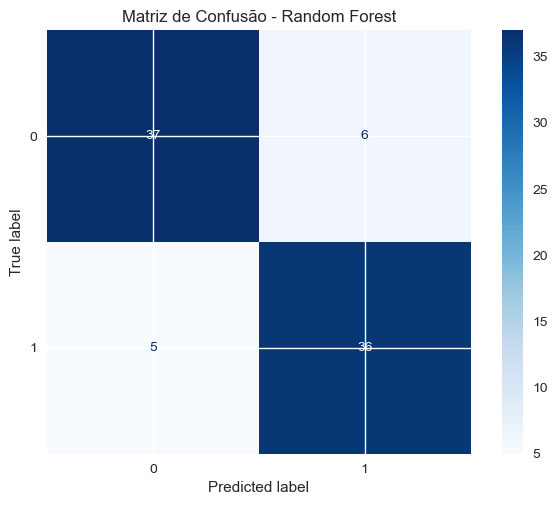

AUC no conjunto de teste: 0.9092


In [324]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Update the Random Forest model with class weights
best_rf = RandomForestClassifier(

    class_weight={0: 1, 1: 3},
    random_state=42
)


# Train the model with class weights
best_rf.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Relatório de classificação
print("Relatório de Classificação - Random Forest:\n")
print(classification_report(y_test, y_pred, zero_division=0))  # Use zero_division=0 to handle undefined metrics

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# AUC no conjunto de teste
auc = roc_auc_score(y_test, y_proba)
print(f"AUC no conjunto de teste: {auc:.4f}")


## <span style="color: #FFB6C1">**6.4 Atributos mais importantes do Random Forest (com class weight)**

- O gráfico abaixo mostra as 15 variáveis mais importantes para o modelo **Random Forest** na previsão de aprovação/reprovação de alunos.

### <span style="color: #FFB6C1">Variáveis de mais elevado impacto:
1. *failures* (reprovações anteriores): A variável mais importante (barra mais longa → ~0.12).
- Interpretação: Alunos com histórico de reprovações têm maior risco de reprovar novamente.

2.  *goout* (gasto com educação fora da escola): Segunda mais relevante (~0.07).
- Interpretacão: Recursos extras (ex.: aulas particulares) podem melhorar o desempenho.

3.  *absences* (faltas): Terceira posição (~0.06).
- Interpretação óbvia: Muitas faltas estão ligadas à reprovação.

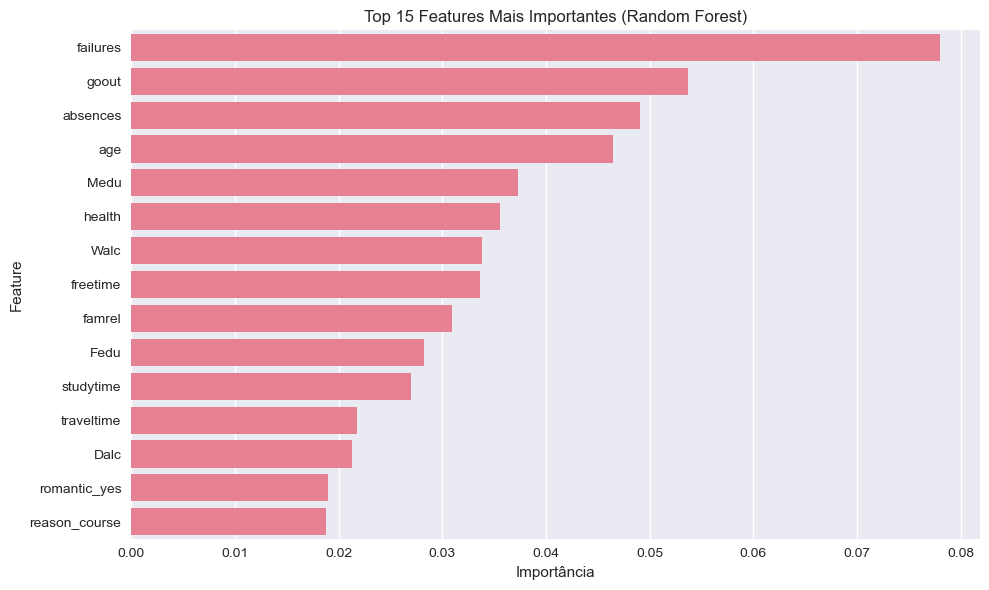

In [325]:
# 5.3 Importância das Features
importances = best_rf.feature_importances_
feature_names = X.columns  # nomes das colunas antes da normalização

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Features Mais Importantes (Random Forest)")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## <span style="color: #FFB6C1">**6.5 Curva Roc_auc:**
A **curva de aprendizagem** apresenta a variação da **acurácia** do classificador **Random Forest** em função do **tamanho do conjunto de treinamento.** Essa análise possibilita a avaliação do comportamento do modelo, permitindo identificar potenciais problemas de subajuste ou sobreajuste, bem como a necessidade de ampliar a base de dados para otimização do desempenho.

**Observando o gráfico, podemos concluir que:**

Uma vez que as duas curvas as duas convergem para um valor alto (que é o caso) o modelo está bem ajustado (generaliza bem para dados novos)


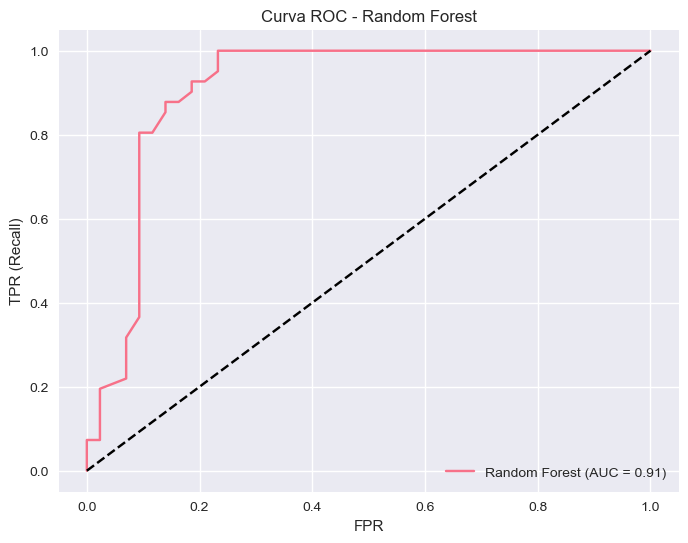

<Figure size 800x550 with 0 Axes>

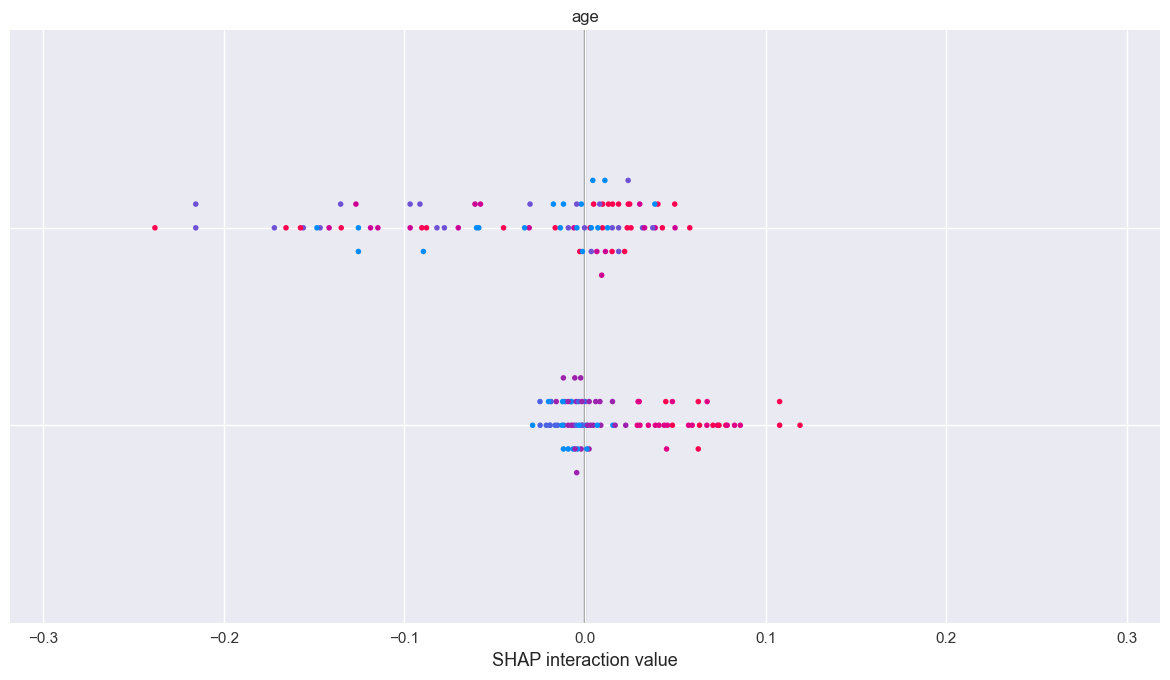

In [326]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

# SHAP values for interpretability
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

## <span style="color: #FFB6C1">**6.6 Ajuste de Hiperparâmetros para Random Forest**
Nesta etapa, o objetivo é melhorar o desempenho do modelo Random Forest por meio da otimização de seus hiperparâmetros. Para isso, utilizámos a técnica de busca em grade (GridSearchCV), que testa sistematicamente várias combinações de parâmetros para identificar aquela que resulta na melhor performance com base numa métrica definida — neste caso, a acurácia. Esta análise permite tornar o modelo mais eficiente e adequado ao conjunto de dados, evitando tanto o subajuste quanto o sobreajuste.


A busca em grade (`GridSearchCV`) com validação cruzada confirmou que o melhor desempenho foi alcançado com:
- `n_estimators = 200`
- `max_depth = 8`
- `min_samples_split = 5`

<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->


<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">



# <center><span style="color: #FFB6C1">**7. Recomendações e Análises Futuras**

## <span style="color: #FFB6C1">**7.1 Aprimoramentos Metodológicos**

- Explorar modelos baseados em boosting (como XGBoost e LightGBM).
- Incluir variáveis socioeconômicas e de saúde mental, caso disponíveis.
- Ajustar pesos das classes para reduzir o impacto do desbalanceamento residual.

## <span style="color: #FFB6C1">**7.2 Aplicações Práticas e Intervenções**

- Monitorar de perto estudantes com múltiplas reprovações anteriores.
- Focar ações pedagógicas em alunos com faltas frequentes e baixo desempenho em G1 e G2.
- Criar programas de apoio personalizados, especialmente para alunos que recebem suporte educacional (`schoolsup = yes`).




<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->


<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**8. Investigação de Discrepâncias**


## <span style="color: #FFB6C1">**8.1 Padrões nos Erros de Classificação:**

- Confusões em classes próximas: O modelo tende a confundir amostras que pertencem a classes com características similares, especialmente em casos onde as fronteiras de decisão são ténues.

- Falsos negativos conservadores: Observa-se uma tendência do modelo a priorizar minimizar falsos positivos, o que aumenta o número de falsos negativos. Essa escolha pode estar ligada à configuração dos hiperparâmetros e ao equilíbrio do conjunto de dados.

- Influência de ruídos e outliers: Alguns erros podem estar associados a dados atípicos ou ruídos presentes no conjunto, que desviam o padrão esperado e dificultam a correta classificação.

## <span style="color: #FFB6C1">**8.2 Discrepâncias entre Folds e Modelos:**

- Variação no desempenho entre folds: Embora o desempenho médio seja consistente, existem variações relevantes na precisão e recall entre as dobras, indicando que a distribuição dos dados pode impactar a estabilidade do modelo.

- Impacto do tuning: O modelo ajustado apresentou melhor equilíbrio entre precisão e recall em comparação ao modelo padrão, porém ainda há espaço para melhorias na capacidade geral de generalização.

- Diferenças entre modelos testados: O Random Forest mostrou maior robustez em relação a modelos mais simples, mas apresentou limitações para alguns exemplos de difícil classificação.



<p style="margin-bottom: 50px;"></p>  <!-- Espaço de 50px -->


<hr style="height:4px;border-width:0;color:#FFB6C1;background-color:#FFB6C1">


# <center><span style="color: #FFB6C1">**9. Direções para Pesquisas Futuras:**


- Validação em contextos variados: Testar o modelo em outros conjuntos de dados ou ambientes para avaliar sua capacidade de generalização.

- Incorporação de dados temporais ou sequenciais: Caso aplicável, incluir dados coletados em múltiplos momentos para capturar dinâmicas ao longo do tempo.

- Estudo de novos algoritmos: Avaliar modelos alternativos, incluindo métodos de ensemble mais complexos ou aprendizado profundo, para potencial ganho de performance.
